In [ ]:
"""
Author: Yang Hu
1. This file gives a script to constrain cosmological parameters (H0, Omega0, Omegak, MB, etc.)
using strong gravitational lenses (lenses) and type Ia supernovae (SNe) with non-parametric analysis.
2. We use baryon accoustic oscillation data (BAO) to obtain an interpolated curve for Hubble parameter Hz via
Gaussian Process (GP). GP is carried out using george package.
3. For lenses, we use simulated LSST data. For SNe, we use simulated Roman data. For BAO, we use simulated DESI data.
4. Constraints on parameters are obtained via Markov Chain Monte Carlo (MCMC) using emcee package.
"""

In [4]:
"""
standard imports for data analysis and astropy.cosmology to compute astrophysical quantities with ease
"""

import numpy as np
import pandas as pd
import emcee
import corner
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.optimize import minimize

import george
from george import kernels
from astropy.cosmology import FlatwCDM, LambdaCDM, wCDM

In [5]:
"""
Load source data.
"""

#load and rename Lens data
use_lens = 'Goldstein2019' # choose between Goldstein2019, Uniform or Arendse2023
real_number = 1000 # equivalent number of lenses involved

if use_lens == 'Goldstein2019':
    data1 = pd.read_csv("../data/zlens_zsource_310LSSTLike_20.csv",skiprows=1,header=None) # Goldstein et al. (2019)
    zlens = np.array(data1[0])
    zsource = np.array(data1[1])
    ddt_err = np.array(data1[2])*np.sqrt(310/1000) # To estimate the uncertainty for 1000 lenses, we apply a factor of sqrt(N).
elif use_lens == 'Uniform':
    data1 = pd.read_csv("../data/uniform_1000LSSTLike_20.csv",skiprows=1,header=None)
    zlens = np.array(data1[0])
    zsource = np.array(data1[1])
    ddt_err = np.array(data1[2])
elif use_lens == 'Arendse2023':
    data1 = pd.read_csv("../data/Arendse23_redshifts_20.csv",skiprows=1,header=None) # Goldstein et al. (2019)
    zlens = np.array(data1[1])
    zsource = np.array(data1[0])
    ddt_err = np.array(data1[2])
else:
    print('Lens not defined')


#load and rename SNe data
data2 = pd.read_csv("../data/lcparam_WFIRST_G10.txt", delimiter=' ', skiprows=1, header=None)
data3 = pd.read_csv("../data/syscov_WFIRST.txt", delimiter=' ', skiprows=0, header=None)
zcmb = data2[1]

#for a measure of the uncertainty of SNe measurement, we need the covariance matrix in the following way
m_err = data2[5]
sys_err = np.array(data3)
D_stat = np.diag(m_err**2)
C_sys = sys_err.reshape((len(data2), len(data2)))
C = D_stat + C_sys
C_inv = np.linalg.inv(C)

#load and rename BAO data
data4 = pd.read_csv("../data/DESI_HZ_error.txt", delimiter=' ', skiprows=1, header=None) 
zBAO = data4[0]
sigHz = data4[1]

In [7]:
"""
Although this is a non-parametric approach, we still need to set a mock universe and generate the "true value" of parameters which are then
used to compute the difference between true and measured (simulated) values which in turn are used to get
the constraints of parameters.
"""
H0_mock, Om0_mock, Ok0_mock, w_mock, M_mock = 72, 0.3, 0.00, -1, -19.2
cosmo_mock = wCDM(H0=H0_mock, Om0=Om0_mock, Ode0=1.-Om0_mock-Ok0_mock, w0=w_mock)

#compute mock time-delay distance for lenses
dd_mock = cosmo_mock.angular_diameter_distance(z=zlens)
ds_mock = cosmo_mock.angular_diameter_distance(z=zsource)
dds_mock = cosmo_mock.angular_diameter_distance_z1z2(z1=zlens, z2=zsource)
ddt_mock = (1. + zlens) * dd_mock * ds_mock / dds_mock

#compute mock luminosity distance for SNe
dl_mock = cosmo_mock.luminosity_distance(z=zcmb)
m_mock = 5*np.log10(np.array(dl_mock))+25+M_mock

#compute mock Hz from BAO data
Hz_mock = cosmo_mock.H(z=zBAO)

In [8]:
"""
Get a starting point of GP hyperparameters from BAO data using george package.
Constraints are obtained by MCMC and here we define the relevant prior and likelihood functions.
"""

#compute a rough interpolation as starting values for MCMC
gp = george.GP(1*np.var(Hz_mock)*kernels.ExpSquaredKernel(1), fit_kernel=True,
               mean=np.mean(Hz_mock), white_noise=None)
print(gp.parameter_names)
gp.compute(zBAO, sigHz)

#defining mcmc functions
def lnprob(p):
    if np.any((-100 > p[1:]) + (p[1:] > 100)):
        return -np.inf
    gp.set_parameter_vector(p)
    return gp.log_likelihood(Hz_mock, quiet=True)
labels = ["$α$", "$l$"]

#Set up the sampler.
nwalkers, nsamples, ndim = 32, 8000, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

#Initialize the walkers.
p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0')


In [15]:
"""
run MCMC on hyperparameters using emcee package. After loading a sample file, we can plot a corner plot showing how well constraints are placed on each interested
hyperparamters by the data.
"""

run_mcmc = False
save_mcmc = False
plot_mcmc = False
save_plot_mcmc = False

if run_mcmc:
    print("Sampling...")
    sampler.run_mcmc(p0, nsamples, progress=True);

if save_mcmc:
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=500, thin=4, flat=True)
    sample_data = pd.DataFrame(flat_samples)
    sample_data.to_csv(
    "../sample/amp_ls_%ix%i.csv"
    % (nwalkers, nsamples),
    index=False, header=None
)

if plot_mcmc:
    flat_samples = pd.read_csv("../sample/amp_ls_%ix%i.csv" % (nwalkers, nsamples), skiprows=1, header=None)
    fig = corner.corner(
        flat_samples, labels=labels,show_titles=True, quantiles=[0.16, 0.5, 0.84],
        title_fmt='.3f', use_math_text=True, plot_datapoints=False, levels=[0.68, 0.95], fill_contours=True,
        contour_kwargs={"colors": ["black"], "linestyles": ["--"], "linewidths": [2,0]},
        contourf_kwargs={"colors": ["white", "grey", "black"],"alpha":0.7}
    )
    fig.suptitle("Hyperparameters, %ix%i" % (nwalkers, nsamples), y=1.02,
                 fontsize=16, fontweight='bold', ha='center')
    if save_plot_mcmc:
        fig.savefig("../plot/amp_ls_corner_%ix%i.png" % (nwalkers, nsamples), bbox_inches='tight')
        display("Plot saved")
    else:
        display("Plot not saved")

'Plot saved'

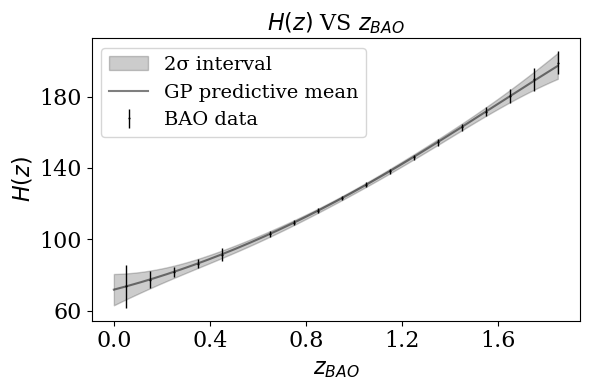

In [14]:
"""
plot interpolated curve with optimal hyperparameters for testing
"""

save_figure = True

plt.rcParams["figure.figsize"] = (6, 4)
#here we need to replace the two numercial values by whatever values we get from MCMC
amp, ls = 10.163, 1.924
gp_optimal = george.GP(amp*np.var(Hz_mock)*kernels.ExpSquaredKernel(ls), fit_kernel=True,
               mean=np.mean(Hz_mock), white_noise=None)
gp_optimal.compute(zBAO, sigHz)

z_pred = np.linspace(0., max(zBAO), 500)
pred, pred_var = gp_optimal.predict(Hz_mock, z_pred, return_var=True)

plt.rc('font', family='serif', size=10)
plt.fill_between(z_pred, pred - 2 * np.sqrt(pred_var), pred + 2 * np.sqrt(pred_var),
                 color="k", alpha=0.2, label='2σ interval')
plt.plot(z_pred, pred, "k", lw=1.5, alpha=0.5, label='GP predictive mean')
plt.errorbar(zBAO, Hz_mock, yerr=sigHz, fmt=".k", markersize=1, lw=1, label='BAO data')

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks([0.0, 0.4, 0.8, 1.2, 1.6])
plt.yticks([60,100,140,180])
plt.xlabel("$z_{BAO}$",fontsize=16)
plt.ylabel("$H(z)$",fontsize=16)
plt.title("$H(z)$ VS $z_{BAO}$", fontsize=16)
plt.legend(fontsize=14)  # Add legend
plt.tight_layout()
if save_figure:
    plt.savefig("../plot/optimal_hyperparameters.png", bbox_inches='tight',dpi=512)
    display("Plot saved")
else:
    display("Plot not saved")
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


In [17]:
"""
GP interpolate Hz from BAO data using george package
"""

#function to get GP interpolation
def get_gp_interp(zBAO, Hz_mock, sigHz):
    """
    Compute the GP interpolation with the error covariance matrix
    TO DO: Marginalise over kernel hyperparameters
    zBAO: array of z from BAO
    Hz_mock: array of Hz from BAO
    sigHz: array of uncertainty of Hz
    """
    #the 2 optical numerical values of hyperparameters are obtained via MCMC in a seperate script:
    #"HzGP_constraint.ipynb"
    #you can also find the values in "amp_ls_corner_32x8000.png"
    gp = george.GP(10.163*np.var(Hz_mock)*kernels.ExpSquaredKernel(1.924),
               mean=np.mean(Hz_mock), white_noise=None)
    Hz = Hz_mock
    Hz_err = sigHz
    #define the redshift region for predicting the GP fit
    z_step = np.linspace(0., max(zBAO), 4000)
    gp.compute(zBAO, Hz_err)
    Hz_gp = gp.predict(Hz, z_step, return_cov=False)
    return z_step, Hz_gp

z_step, Hz_gp = get_gp_interp(zBAO, Hz_mock, sigHz)
#normalise the E(z)
Ez_gp = Hz_gp/Hz_gp[0]
#this is the normalised Hz interpolation curve

In [18]:
"""
We want to get cosmological distances in likelihood function in a non-parametric way.
"""

c = 299792.458 #in km/s

#function to get time-delay distance in a non-parametric way
def get_model_indep_dist_ddt(zl, zs, z_step, Ez_gp, h0, ok):
    """
    Doesn't account for errors in the GP fit as of now
    zl: float of z at lenses
    zs: float of z at source to integrate till
    z_step: float, the baseline step for integrating
    Ez_gp: array of normalised Hubble parameter from GP interpolation
    h0: float, a value of Hubble's constant
    ok: float, a value of curvature density parameter
    """
    cond_l = z_step <= zl
    cond_s = z_step <= zs
    Ez_gp_l = Ez_gp[cond_l]
    Ez_gp_s = Ez_gp[cond_s]
    dh = c/h0

    int_comov_l = simps(1/Ez_gp_l, z_step[cond_l])
    int_comov_s = simps(1/Ez_gp_s, z_step[cond_s])

    if ok < 0.:
        dm_l = dh/np.sqrt(abs(ok))*np.sin(np.sqrt(abs(ok))*int_comov_l)
        dm_s = dh/np.sqrt(abs(ok))*np.sin(np.sqrt(abs(ok))*int_comov_s)
    elif ok == 0.:
        dm_l = dh*int_comov_l
        dm_s = dh*int_comov_s
    elif ok > 0.:
        dm_l = dh/np.sqrt(abs(ok))*np.sinh(np.sqrt(abs(ok))*int_comov_l)
        dm_s = dh/np.sqrt(abs(ok))*np.sinh(np.sqrt(abs(ok))*int_comov_s)

    da_l = dm_l/(1+zl)
    da_s = dm_s/(1+zs)
    da_ls = (1/(1+zs) *
             (dm_s * np.sqrt(1 + ok * (dm_l / dh)**2) - dm_l * np.sqrt(1 + ok * (dm_s / dh)**2)))

    ddt = (1 + zl) * da_l * da_s / da_ls
    return ddt

#function to get luminosity distance in a non-parametric way
def get_model_indep_dist_dl(z, z_step, Ez_gp, h0, ok):
    """
    Doesn't account for errors in the GP fit as of now
    z: float of z from SNe
    z_step: float, the baseline step for integrating
    Ez_gp: array of normalised Hubble parameter from GP interpolation
    h0: float, a value of Hubble's constant
    ok: float, a value of curvature density parameter
    """
    cond = z_step <= z
    Ez_gp = Ez_gp[cond]
    if ok < 0.:
        int_comov = simps(1/Ez_gp, z_step[cond])
        comov_curv = np.sqrt(abs(ok)) * int_comov
        dl_int = c*np.sin(comov_curv) * (1+z) / (np.sqrt(abs(ok)))
    elif ok > 0.:
        int_comov = simps(1/Ez_gp, z_step[cond])
        comov_curv = np.sqrt(abs(ok)) * int_comov
        dl_int = c*np.sinh(comov_curv) * (1+z) / (np.sqrt(abs(ok)))
    elif ok == 0.:
        int_comov = simps(1/Ez_gp, z_step[cond])
        comov_curv = int_comov
        dl_int = c*comov_curv * (1+z)
    dl_int /= h0
    return dl_int

In [22]:
"""
This cell defines the loss function of MCMC
Constraints are obtained by MCMC and here we define the relevant prior and likelihood functions
"""

use_Lens = True
use_SNe = False

max_likelihood_test = True

#use uniform priors for all parameters
def log_prior(theta):
    """
    theta: list of floats, folded cosmological parameters.
    """
    if use_SNe:
        h0, ok, M = theta
        if 0. <= h0 <= 150. and -2. <= ok <= 2. and -25. <= M <= -15.:
            return 0.0
        else:
            return -np.inf
    else:
        h0, ok = theta
        if 0. <= h0 <= 150. and -2. <= ok <= 2.:
            return 0.0
        else:
            return -np.inf

#create a time-delay distance list
def get_ddt_list(zlens, zsource, z_step, Ez_gp, h0, ok):
    ddt_list = []
    for zl, zs in zip(zlens, zsource):
        ddt_list.append(get_model_indep_dist_ddt(zl, zs, z_step, Ez_gp, h0, ok))
    return np.array(ddt_list)

#use a chi-square likelihood function
def log_likelihood(theta, zlens, zsource, ddt_err, zcmb, C_inv, z_step, Ez_gp):
    if use_SNe:
        h0, ok, M = theta
    else:
        h0, ok = theta
    chi_sq = 0
    if use_Lens:
        ddt_list = get_ddt_list(zlens, zsource, z_step, Ez_gp, h0, ok)
        if np.all(ddt_list >= 0):
            chi_sq += np.sum((ddt_list.value - ddt_mock) ** 2 / (ddt_list.value * ddt_err) ** 2)
        else:
            return -np.inf
    if use_SNe:
        z_list_dl = list(zcmb)
        dl = np.zeros(len(zcmb))
        for z in zcmb:
            dl[z_list_dl.index(z)] = get_model_indep_dist_dl(z, z_step, Ez_gp, h0, ok)
        if np.all(dl >=0):
            m = 5*np.log10(dl)+25+M
            del_m = m_mock - m
            chi_sq += np.dot(del_m.T, np.dot(C_inv, del_m))
        else:
            return -np.inf
    return -0.5 * chi_sq

def log_probability(theta, zlens, zsource, ddt_err, zcmb, C_inv, z_step, Ez_gp):
    """
    theta: list of floats, folded cosmological parameters.
    zlens: array of z at lens
    zsource: array of z at source
    ddt_err: array of uncertainty of time-delay distance
    zcmb: array of z of cmb, obtained for SNe data
    C_inv: covariance matrix indicating uncertainty of SNe data
    z_step: float, the baseline step for integrating
    Ez_gp: array of normalised Hubble parameter from GP interpolation
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, zlens, zsource, ddt_err, zcmb, C_inv, z_step, Ez_gp)


"""
Naming
"""
name = ''
if use_Lens:
    if use_lens =='Goldstein2019':
        name += 'LSST'
    elif use_lens =='Uniform':
        name += 'LSSTu'
    else:
        name += 'LSSTa'
if use_SNe:
    if name == '':
        name += 'Roman'
    else:
        name += '+Roman'

"""
Maximum likelihood test
"""
if max_likelihood_test:
    nll = lambda *args: -log_likelihood(*args)
    if use_SNe:
        initial = np.array([75., 0.02, -19.])
        soln = minimize(nll, initial, args=(zlens, zsource, ddt_err, zcmb, C_inv, z_step, Ez_gp))
        H0_ml, Ok_ml, M_ml = soln.x
        print("Maximum likelihood estimates:")
        print("H0_ml = {0:.3f}".format(H0_ml))
        print("Ok_ml = {0:.3f}".format(Ok_ml))
        print("M_ml = {0:.3f}".format(M_ml))
    else:
        initial = np.array([75., 0.02])
        soln = minimize(nll, initial, args=(zlens, zsource, ddt_err, zcmb, C_inv, z_step, Ez_gp))
        H0_ml, Ok_ml = soln.x
        print("Maximum likelihood estimates:")
        print("H0_ml = {0:.3f}".format(H0_ml))
        print("Ok_ml = {0:.3f}".format(Ok_ml))

print(name)

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [ ]:
"""
presettings for MCMC
"""
nwalkers = 16
nsamples = 1200

if use_SNe:
    startpos = [70., 0.02, -19.]  # H0, Ok, M
    labels = ["$H_0$", "$Ω_{K}$", "M"]
    parameters = [H0_mock, Ok0_mock, M_mock]
else:
    startpos = [70., 0.02]  # H0, Ok
    labels = ["$H_0$", "$\Omega_{K}$"]
    parameters = [H0_mock, Ok0_mock]

In [ ]:
#MCMC
run_MCMC = True
save_MCMC = True
plot_MCMC = True
save_plot_MCMC = True

if run_MCMC:
    pos = startpos + 1e-4 * np.random.randn(nwalkers, len(startpos))
    nwalkers, ndim = pos.shape
    display("Sampling cosmological parameters...")
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=[zlens, zsource, ddt_err, zcmb, C_inv, z_step, Ez_gp]
    )
    sampler.run_mcmc(pos, nsamples, progress=True);

if save_MCMC:
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=200, thin=4, flat=True)
    sample_data = pd.DataFrame(flat_samples)

    sample_data.to_csv(
        "GP_samples/%s+HzGP_%ix%i.csv"
        % (name, nwalkers, nsamples),
        index=False, header=labels
    )
#read data
if plot_MCMC:
    flat_samples = pd.read_csv("GP_samples/%s+HzGP_%ix%i.csv"
                               % (name, nwalkers, nsamples), skiprows=1, header=None
                            )
    #plot
    fig = corner.corner(
        flat_samples, labels=labels, show_titles=True, quantiles=[0.16, 0.5, 0.84],
        title_fmt='.3f', use_math_text=True, truths=[H0_mock, Ok0_mock, MB_mock],
        plot_datapoints=False, smooth=0, levels=[0.68, 0.95], fill_contours=True,
        contour_kwargs={"colors": ["black"], "linestyles": ["--"], "linewidths": [2,0]},
        contourf_kwargs={"colors": ["white", "grey", "black"],"alpha":0.7}
    )
    fig.suptitle('%s samples, H(z) GP-fitted, mock=%s'
        % name, parameters), y=1.02, fontsize=16, fontweight='bold', ha='center')
    #save
    if save_plot_MCMC:
        fig.savefig("GP_plots/%s+HzGP_%ix%i_corner.png"
                  % (name, nwalkers, nsamples)
                  , bbox_inches='tight'
                )
        display("Plot saved")
    else:
        display("Plot not saved")